# 🐶 Dog Image Denoising Project
This notebook implements Linear PCA-based and U-Net-based image denoisers on CIFAR-10 dogs.
Technologies: **PyTorch, CIFAR-10, GPU acceleration.**

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.utils.data import DataLoader, TensorDataset
from nets import UNet  # Your provided UNet implementation

from IPython.display import display, HTML

display(HTML("""
<style>
div.output pre {
    white-space: pre-wrap;
    word-break: break-word;
}
</style>
"""))

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [10]:
def show_image(xs):
    """Display a list of CIFAR-10 images in a table.
    Images may be flattened or unflattened. 
    Assumes floats in range [0,1] representing colors"""
    xs = xs.cpu()
    n = len(xs)
    fig, axs = plt.subplots(1, n)
    for i, ax in enumerate(axs):
        x = xs[i].reshape(3, 32, 32).moveaxis(0, -1)
        x = torch.clamp(x, 0., 1.)
        ax.imshow(x)
        ax.axis('off')
    return fig


In [11]:
dogs_train, dogs_val = torch.load('data.pt', map_location=device)
train_loader = DataLoader(TensorDataset(dogs_train), batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(TensorDataset(dogs_val), batch_size=50, drop_last=True)


In [12]:
class LinearDenoiser(nn.Module):
    def __init__(self, d=500):
        super().__init__()
        self.d = d

    def forward(self, x):
        x_flat = x.flatten(start_dim=1)
        z = self.encode(x_flat)
        x_hat = self.decode(z)
        return x_hat.view(-1, 3, 32, 32)

    def encode(self, x_flat):
        return (x_flat - self.mean) @ self.components

    def decode(self, z):
        return z @ self.components.T + self.mean

    def fit(self, x):
        x_flat = x.flatten(start_dim=1)
        self.mean = x_flat.mean(0, keepdim=True)
        x_centered = x_flat - self.mean
        cov = x_centered.T @ x_centered / x_centered.shape[0]
        U, S, V = torch.svd(cov)
        self.components = U[:, :self.d]

linear_model = LinearDenoiser()
linear_model.fit(dogs_train)


In [13]:
unet_model = UNet().to(device)
loss_fn = nn.MSELoss()
optimizer = SGD(unet_model.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs = 20
train_losses, val_losses = [], []

def eval_val_mse(model):
    model.eval()
    mse = 0.
    with torch.no_grad():
        for (x,) in val_loader:
            x = x.to(device)
            x_noisy = x + 0.1 * torch.randn_like(x)
            x_hat = model(x_noisy)
            mse += loss_fn(x_hat, x) / len(val_loader)
    return mse.item()

for epoch in range(num_epochs):
    unet_model.train()
    epoch_loss = 0.
    for (images,) in train_loader:
        images = images.to(device)
        noisy = images + 0.1 * torch.randn_like(images)

        optimizer.zero_grad()
        output = unet_model(noisy)
        loss = loss_fn(output, images)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    val_mse = eval_val_mse(unet_model)
    train_losses.append(epoch_loss)
    val_losses.append(val_mse)
    scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss={epoch_loss:.4f} Val MSE={val_mse:.4f}")


Epoch 1/20: Train Loss=0.0274 Val MSE=0.0051
Epoch 2/20: Train Loss=0.0047 Val MSE=0.0044
Epoch 3/20: Train Loss=0.0040 Val MSE=0.0031
Epoch 4/20: Train Loss=0.0036 Val MSE=0.0031
Epoch 5/20: Train Loss=0.0034 Val MSE=0.0026
Epoch 6/20: Train Loss=0.0031 Val MSE=0.0026
Epoch 7/20: Train Loss=0.0030 Val MSE=0.0025
Epoch 8/20: Train Loss=0.0030 Val MSE=0.0026
Epoch 9/20: Train Loss=0.0030 Val MSE=0.0025
Epoch 10/20: Train Loss=0.0029 Val MSE=0.0024
Epoch 11/20: Train Loss=0.0027 Val MSE=0.0024
Epoch 12/20: Train Loss=0.0028 Val MSE=0.0025
Epoch 13/20: Train Loss=0.0027 Val MSE=0.0025
Epoch 14/20: Train Loss=0.0028 Val MSE=0.0023
Epoch 15/20: Train Loss=0.0027 Val MSE=0.0023
Epoch 16/20: Train Loss=0.0026 Val MSE=0.0023
Epoch 17/20: Train Loss=0.0027 Val MSE=0.0023
Epoch 18/20: Train Loss=0.0026 Val MSE=0.0022
Epoch 19/20: Train Loss=0.0026 Val MSE=0.0022
Epoch 20/20: Train Loss=0.0026 Val MSE=0.0022


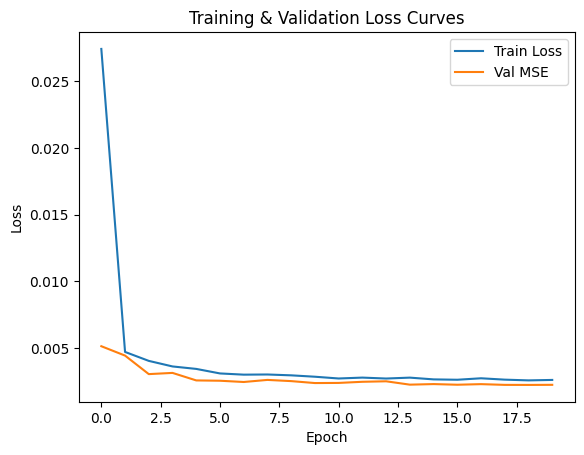

In [14]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss Curves')
plt.show()


Original images


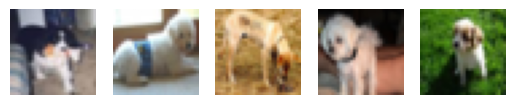

Noisy images


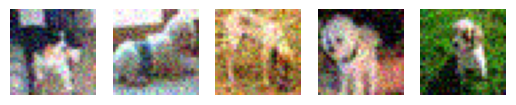

Linear denoising


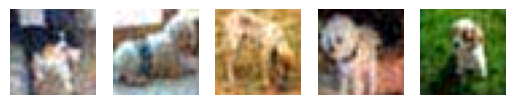

UNet denoising


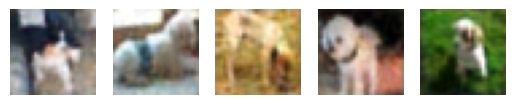

Linear model Val MSE: 0.0026
U-Net model Val MSE: 0.0022


In [15]:
dogs = dogs_val[:5].cpu()
noisy_dogs = dogs + 0.1 * torch.randn_like(dogs)

with torch.no_grad():
    linear_denoise = linear_model(noisy_dogs.to(device)).cpu()
    unet_denoise = unet_model(noisy_dogs.to(device)).cpu()

print("Original images")
show_image(dogs)
plt.show()
print("Noisy images")
show_image(noisy_dogs)
plt.show()
print("Linear denoising")
show_image(linear_denoise)
plt.show()
print("UNet denoising")
show_image(unet_denoise)
plt.show()

linear_final_mse = eval_val_mse(linear_model)
unet_final_mse = eval_val_mse(unet_model)

print(f"Linear model Val MSE: {linear_final_mse:.4f}")
print(f"U-Net model Val MSE: {unet_final_mse:.4f}")


In [20]:
try:
    from torchmetrics.functional import structural_similarity_index_measure as ssim
    dogs_t = dogs.to(device)
    noisy_dogs_t = noisy_dogs.to(device)
    linear_denoise_t = linear_model(noisy_dogs_t)
    unet_denoise_t = unet_model(noisy_dogs_t)
    ssim_noisy = ssim(noisy_dogs_t, dogs_t)
    ssim_linear = ssim(linear_denoise_t, dogs_t)
    ssim_unet = ssim(unet_denoise_t, dogs_t)    
    print(f"noisy model Val SSIM: {ssim_noisy:.4f}")
    print(f"Linear model Val SSIM: {ssim_linear:.4f}")
    print(f"U-Net model Val SSIM: {ssim_unet:.4f}")
except ImportError:
    print("SSIM not computed (requires torchmetrics).")


noisy model Val SSIM: 0.6473
Linear model Val SSIM: 0.8399
U-Net model Val SSIM: 0.8673
